# Drifter Simulation in the JDF -Summer
based off code from file:///Users/rebeccabeutel/Downloads/MattDrifterSimulations.html

In [1]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from salishsea_tools import nc_tools, places

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

%matplotlib inline 
# ^ a magic funtion that renders the figure in the notebook right after the cell and will be stored in the notebook document

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2919/libparcels_random_f11d1616-02c8-4da2-9861-e1bdbd3893a6.so


### Functions
#### Fieldset functions

In [2]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

#### Kernel functions

In [3]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()
    

def WindDrift(particle, fieldset, time):
    (uw, vw) = fieldset.UV_GEM[time, particle.depth, particle.lat, particle.lon]
    particle.lon += uw * 0.03 * particle.dt
    particle.lat += vw * 0.03 * particle.dt


def StokesDrift(particle, fieldset, time):
    (us, vs) = fieldset.UV_WW3[time, particle.depth, particle.lat, particle.lon]
    particle.lon += us * particle.dt
    particle.lat += vs * particle.dt

### Load Drifters and Definitions

In [4]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/ocean/rbeutel/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/rbeutel/MEOPAR/grid/mesh_mask201702.nc',
    'out': './results',
}

In [5]:
# Duration and timestep [s]
length = 10
duration = timedelta(days=length)
dt = 90

In [6]:
n = 1000   # number of particles
# Define Gaussian point cloud in the horizontal
r = 10000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], n).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 250.
zvals = dmin + np.random.random_sample(n)*(dmax-dmin)

### Simulations

In [7]:
start = datetime(2020, 1, 15)
daterange = [start+timedelta(days=i) for i in range(length)]
# Build filenames
Ulist, Vlist, Wlist = [], [], []
for day in range(duration.days):
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

#bring salish sea results into field_set
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

         It will be opened with no decoding. Filling values might be wrongly parsed.


/results2/SalishSea/nowcast-green.201905/15jan20/SalishSea_1h_20200115_20200115
/results2/SalishSea/nowcast-green.201905/16jan20/SalishSea_1h_20200116_20200116
/results2/SalishSea/nowcast-green.201905/17jan20/SalishSea_1h_20200117_20200117
/results2/SalishSea/nowcast-green.201905/18jan20/SalishSea_1h_20200118_20200118
/results2/SalishSea/nowcast-green.201905/19jan20/SalishSea_1h_20200119_20200119
/results2/SalishSea/nowcast-green.201905/20jan20/SalishSea_1h_20200120_20200120
/results2/SalishSea/nowcast-green.201905/21jan20/SalishSea_1h_20200121_20200121
/results2/SalishSea/nowcast-green.201905/22jan20/SalishSea_1h_20200122_20200122
/results2/SalishSea/nowcast-green.201905/23jan20/SalishSea_1h_20200123_20200123
/results2/SalishSea/nowcast-green.201905/24jan20/SalishSea_1h_20200124_20200124


In [8]:
# Set output file name.  Maybe change for each run
fn = f'becca_drifters' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

./results/becca_drifters20200115_20200125.nc


In [9]:
# Execute run
clon, clat = -123.541153, 48.224371  # choose horizontal centre of the particle cloud
lon, lat, z = clon + x_offset, clat + y_offset, zvals
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))
#pset.computeTimeChunk(allow_time_extrapolation=1)
pset.execute(
    pset.Kernel(AdvectionRK4), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-2919/a155e126d3c984af2bd46cd26854cb47_0.so
INFO: Temporary output files are stored in ./results/out-OLQFZXOL.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-OLQFZXOL" to convert these to a NetCDF file during the run.
 91% (788400.0 of 864000.0) |##########  | Elapsed Time: 0:06:52 ETA:   0:00:45

Particle 186 lost !! [-124.74479220002428, 48.45725884651345, 38.655538547462065, 792900.0]


100% (864000.0 of 864000.0) |############| Elapsed Time: 0:07:27 Time:  0:07:27


In [10]:
# Had this cell earlier before but seem to need to run it after simulationto get the outputfiles 
# from the temp directory into my final outfile
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [11]:
ds = xr.open_dataset(outfile)

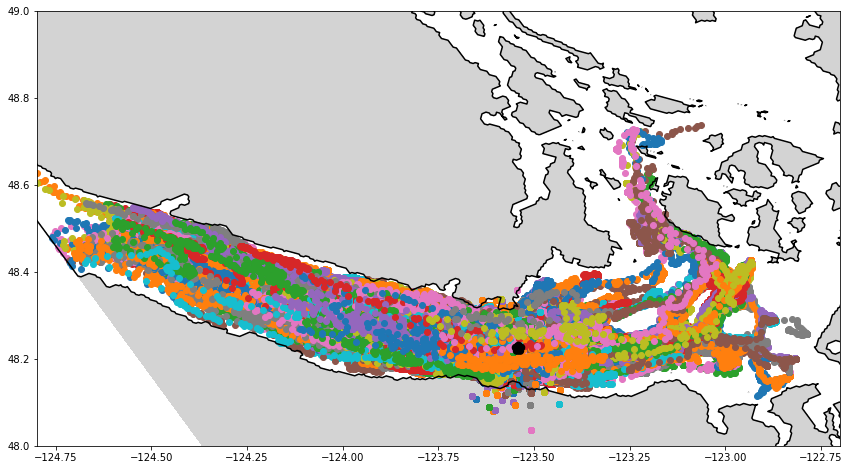

In [12]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin:nmax], ds.lat[traj, nmin:nmax])
ax.scatter(clon,clat,c='k', marker='*', linewidths=8)

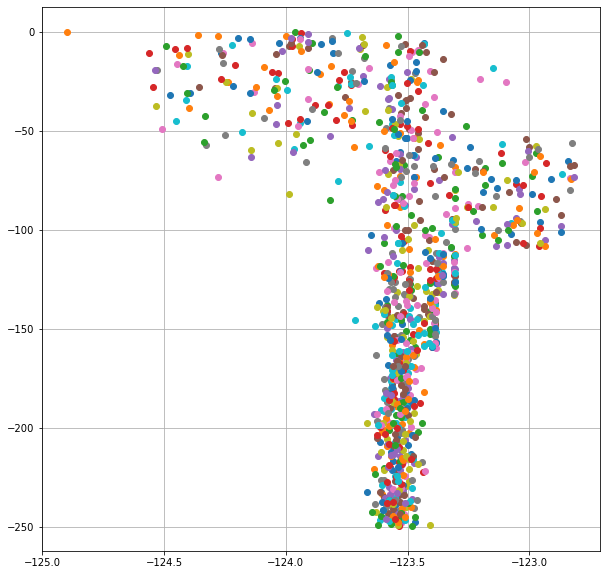

In [13]:
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
for traj in range(n):
    ax.plot(ds.lon[traj, nmax], -ds.z[traj, nmax], 'o')
ax.grid()